# Intro Task, Object Localization 

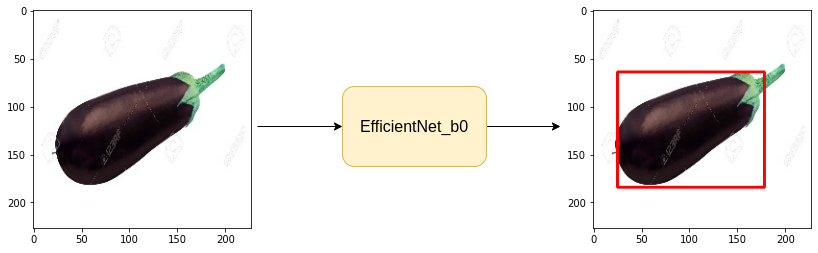

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fthc4svq
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fthc4svq
     |████████████████████████████████| 48.3 MB 1.9 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=113560 sha256=878e97b94ecda523752ea8f747615e2818af5ce8506d16c7d1e9561adcec6825
  Stored in directory: /tmp/pip-ephem-wheel-cache-5p304qtk/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Collecting opencv-python-headless<4.3',
 '  Downloading opencv_python_headless-4.2.0.34-cp37-cp37m-manylinux1_x86_64.whl (21.6 MB)',
 '\x1b[?25l',
 '\x1b[K     |                                | 10 kB 28.1 MB/s eta 0:00:01',
 '\x1b[K     |                                | 20 kB 36.5 MB/s eta 0:00:01',
 '\x1b[K     |                                | 30 kB 26.6 MB/s eta 0:00:01',
 '\x1b[K     |                                | 40 kB 30.5 MB/s eta 0:00:01',
 '\x1b[K     |                                | 51 kB 24.0 MB/s eta 0:00:01',
 '\x1b[K     |                                | 61 kB 26.9 MB/s eta 0:00:01',
 '\x1b[K     |                                | 71 kB 21.0 MB/s eta 0:00:02',
 '\x1b[K     |▏                               | 81 kB 22.4 MB/s eta 0:00:01',
 '\x1b[K     |▏                               | 92 kB 23.9 MB/s eta 0:00:01',
 '\x1b[K     |▏                               

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE= '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'
DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

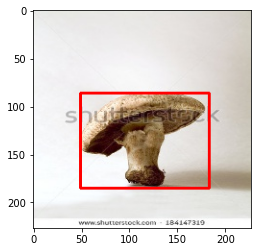

In [7]:
#print(DATA_DIR + '/' + row.img_path)
row = df.iloc[2]
img = cv2.imread(DATA_DIR + '/' + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img);

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                        A.HorizontalFlip(p = 0.5),
                        A.VerticalFlip(p = 0.5),
                        A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                        A.HorizontalFlip(p = 0.5),
                        A.VerticalFlip(p = 0.5),
                        A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjectDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations = None):
    self.df =df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + '/' + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

      img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)

      return img, bbox

In [12]:
trainset = ObjectDataset(train_df, train_augs)
validset = ObjectDataset(valid_df, valid_augs)

In [13]:
print(f"Total examples in the trainset :, {len(trainset)}")
print(f"Total exanples in the validset : {len(validset)}")

Total examples in the trainset :, 148
Total exanples in the validset : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


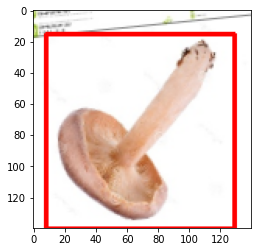

In [14]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img);

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
#print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])


# Create Model

In [18]:
from torch import nn 
import timm

In [39]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):

      bboxes = self.backbone(images)
      if gt_bboxes != None:
        loss = nn.MSELoss()(bboxes, gt_bboxes)
        return bboxes, loss

      return bboxes


In [40]:
model = ObjLocModel()
model.to(DEVICE);


# Create Train and Eval Function

In [41]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

In [42]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()
  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss+=loss.item()

    return total_loss / len(dataloader)

In [43]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images, gt_bboxes)
      
      total_loss+=loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [45]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss

  print(f"epochs : {i + 1} train loss : {train_loss} valid_loss : {valid_loss}")



  0%|          | 0/10 [00:00<?, ?it/s]

AttributeError: ignored

#Inference

In [ ]:
import utils

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya